# Section 4.3 — Interpreting linear models

This notebook contains the code examples from [Section 4.3 Interpreting linear models]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
# RCPARAMS.update({'figure.figsize': (8, 5)})   # good for screen
RCPARAMS.update({'figure.figsize': (5, 3)})  # good for print
# RCPARAMS.update({'text.latex.preamble': r'\usepackage{amsmath}'})
# RCPARAMS.update({'text.usetex': True})
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/lm/interpreting"

<Figure size 640x480 with 0 Axes>

In [3]:
from ministats.utils import savefigure

In [4]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

In [5]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms

## Introduction

In [6]:
# load the dataset
doctors = pd.read_csv("../datasets/doctors.csv")
n = doctors.shape[0]

# fit the model
formula = "score ~ 1 + alc + weed + exrc"
lm2 = smf.ols(formula, data=doctors).fit()

# model degrees of freedom (number of predictors)
p = lm2.df_model

# display the summary table
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     270.3
Date:                Wed, 10 Jul 2024   Prob (F-statistic):           1.05e-60
Time:                        12:22:26   Log-Likelihood:                -547.63
No. Observations:                 156   AIC:                             1103.
Df Residuals:                     152   BIC:                             1115.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     60.4529      1.289     46.885      0.000      57.905      63.000
alc           -1.8001      0.070    -25.726      0.000      -1.938      -1.662
weed          -1.0216      0.476     -2.145      0.034      -1.962      -0.081
exrc           1.7683      0.138     12.809      0.000       1.496       2.041
==============================================================================
Omnibus:                        1.140   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.565   Jarque-Bera (JB):                0.900
Skew:                           0.182   Prob(JB):                        0.638
Kurtosis:                       3.075   Cond. No.                         31.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model fit metrics

### Coefficient of determination

In [7]:
lm2.rsquared

0.8421649167873537

In [8]:
# ALT.
1 - lm2.ssr/lm2.centered_tss

0.8421649167873537

### Adjusted coefficient of determination

In [9]:
lm2.rsquared_adj

0.8390497506713147

In [10]:
# ALT.
1 - (lm2.ssr/(n-p-1)) / (lm2.centered_tss/(n-1))

0.8390497506713146

### F-statistic and associated p-value

In [11]:
lm2.fvalue, lm2.f_pvalue

(270.34350189265825, 1.0512133413867047e-60)

### Log-likelihood

In [12]:
lm2.llf

-547.6259042117637

In [13]:
# ALT.
from scipy.stats import norm
sigmahat = np.sqrt(lm2.scale)
np.sum(np.log(norm.pdf(lm2.resid,scale=sigmahat)))
# Q: Why not exactly the same as lm2.llf?

-547.651992151218

In [14]:
# How lm2.llf is computed:
SSR = np.sum(lm2.resid**2)
nobs2 = n/2.0
llf = -np.log(SSR)*nobs2                # concentrated likelihood
llf -= ( 1+np.log(np.pi/nobs2) )*nobs2  # with likelihood constant
llf

-547.6259042117637

### Information criteria

In [15]:
lm2.aic, lm2.bic

(1103.2518084235273, 1115.4512324525256)

In [16]:
# ALT.
2*(p+1) - 2*lm2.llf,  np.log(n)*(p+1) - 2*lm2.llf

(1103.2518084235273, 1115.4512324525256)

### Other model-fit metrics

The mean squared error (MSE)

In [17]:
from statsmodels.tools.eval_measures import mse

scores = doctors["score"]
scorehats = lm2.fittedvalues
mse(scores,scorehats), lm2.ssr/n

(65.56013803717558, 65.56013803717559)

## Parameter estimates

In [18]:
# estimated parameters
lm2.params

Intercept    60.452901
alc          -1.800101
weed         -1.021552
exrc          1.768289
dtype: float64

In [19]:
# estimated sigma (std. of error term)
sigmahat = np.sqrt(lm2.scale)
sigmahat

8.202768119825624

In [20]:
# ALT.
np.sqrt(lm2.ssr/(n-p-1))

8.202768119825624

## Confidence intervals for model parameters

In [21]:
# standard errors
lm2.bse

Intercept    1.289380
alc          0.069973
weed         0.476166
exrc         0.138056
dtype: float64

In [22]:
lm2.conf_int(alpha=0.05)

,0,1
Intercept,57.905480,63.000321
alc,-1.938347,-1.661856
weed,-1.962309,-0.080794
exrc,1.495533,2.041044


## Hypothesis testing for linear models

### T-tests for individual parameters

Hypothesis testing for slope coefficient

Is there a non-zero slope coefficient?

#### Example: t-test for the variable `weed`


- **Null hypothesis $H_0$**: `weed` has no effect on `score`,
  which is equivalent to $\beta_{\texttt{weed}} = 0$:

  $$
     H_0: \quad
     S \;\sim\; \mathcal{N}(
         {\color{red}
             \beta_0
              + \beta_{\texttt{alc}}\!\cdot\!\textrm{alc}
              + \beta_{\texttt{exrc}}\!\cdot\!\textrm{exrc}
          }, \ \sigma) \qquad \qquad 
  $$

- **Alternative hypothesis $H_A$**: `weed` has an effect on `score`,
  and the slope is not zero, $\beta_{\texttt{weed}} \neq 0$:

  $$ 
     H_A: \quad
     S \;\sim\; \mathcal{N}\left(
          {\color{blue}
             \beta_0
              + \beta_{\texttt{alc}}\!\cdot\!\textrm{alc}
              + \beta_{\texttt{weed}}\!\cdot\!\textrm{weed}
              + \beta_{\texttt{exrc}}\!\cdot\!\textrm{exrc}
          }, \ \sigma \right)
  $$

In [23]:
lm2.tvalues["weed"], lm2.pvalues["weed"], n-p-1

(-2.145370545436854, 0.033511561813423775, 152.0)

Calculate the $t$ statistic:

In [24]:
obst_weed = (lm2.params["weed"] - 0) / lm2.bse["weed"]
obst_weed  # = lm2.tvalues["weed"]

-2.145370545436854

Calculate the associated $p$-value

In [25]:
from scipy.stats import t as tdist

pleft = tdist(df=n-p-1).cdf(obst_weed)
pright = 1 - tdist(df=lm2.df_resid).cdf(obst_weed)
pvalue_weed = 2 * min(pleft, pright)
pvalue_weed  # = lm2.pvalues["weed"]

0.033511561813423775

In [26]:
lm2.tvalues

Intercept    46.885245
alc         -25.725654
weed         -2.145371
exrc         12.808529
dtype: float64

In [27]:
lm2.df_resid, n-p-1

(152.0, 152.0)

In [28]:
lm2.pvalues

Intercept    2.756807e-92
alc          2.985013e-57
weed         3.351156e-02
exrc         6.136296e-26
dtype: float64

### F-test for the overall model

In [29]:
lm2.fvalue

270.34350189265825

In [30]:
# ALT.
F = lm2.mse_model / lm2.mse_resid
F

270.34350189265825

In [31]:
lm2.f_pvalue

1.0512133413867047e-60

In [32]:
# ALT.
from scipy.stats import f as fdist
fdist(dfn=p, dfd=n-p-1).sf(F)

1.0512133413867047e-60

### F-test for a submodel

In [33]:
formula2nw = "score ~ 1 + alc + exrc"
lm2_noweed = smf.ols(formula2nw, data=doctors).fit()
F_noweed, p_noweed, _ = lm2.compare_f_test(lm2_noweed)
F_noweed, p_noweed

(4.602614777227957, 0.033511561813425135)

#### The F-statistic is the same as the t-statistic

In [34]:
F_noweed, obst_weed**2, lm2.tvalues["weed"]**2

(4.602614777227957, 4.602614777228025, 4.602614777228025)

In [35]:
p_noweed, pvalue_weed, lm2.pvalues["weed"]

(0.033511561813425135, 0.033511561813423775, 0.033511561813423775)

## Assumptions checks and diagnostics

Are the assumptions for the linear model satisfied?

### Residuals plots

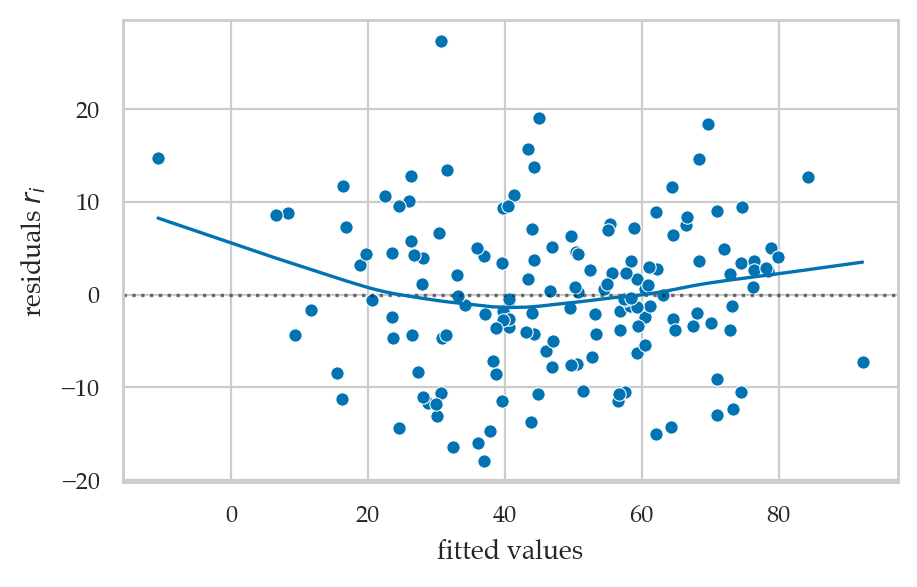

In [36]:
from ministats import plot_resid
plot_resid(lm2, lowess=True);

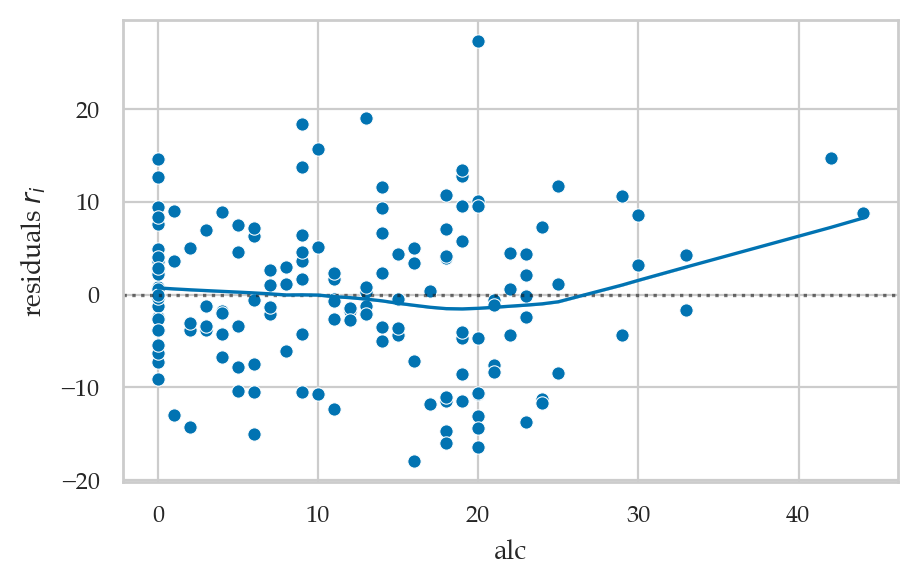

In [37]:
from ministats import plot_resid
plot_resid(lm2, pred="alc", lowess=True);

Saved figure to figures/lm/interpreting/sleep_scores_resid_plots_with_lowess.pdf
Saved figure to figures/lm/interpreting/sleep_scores_resid_plots_with_lowess.png


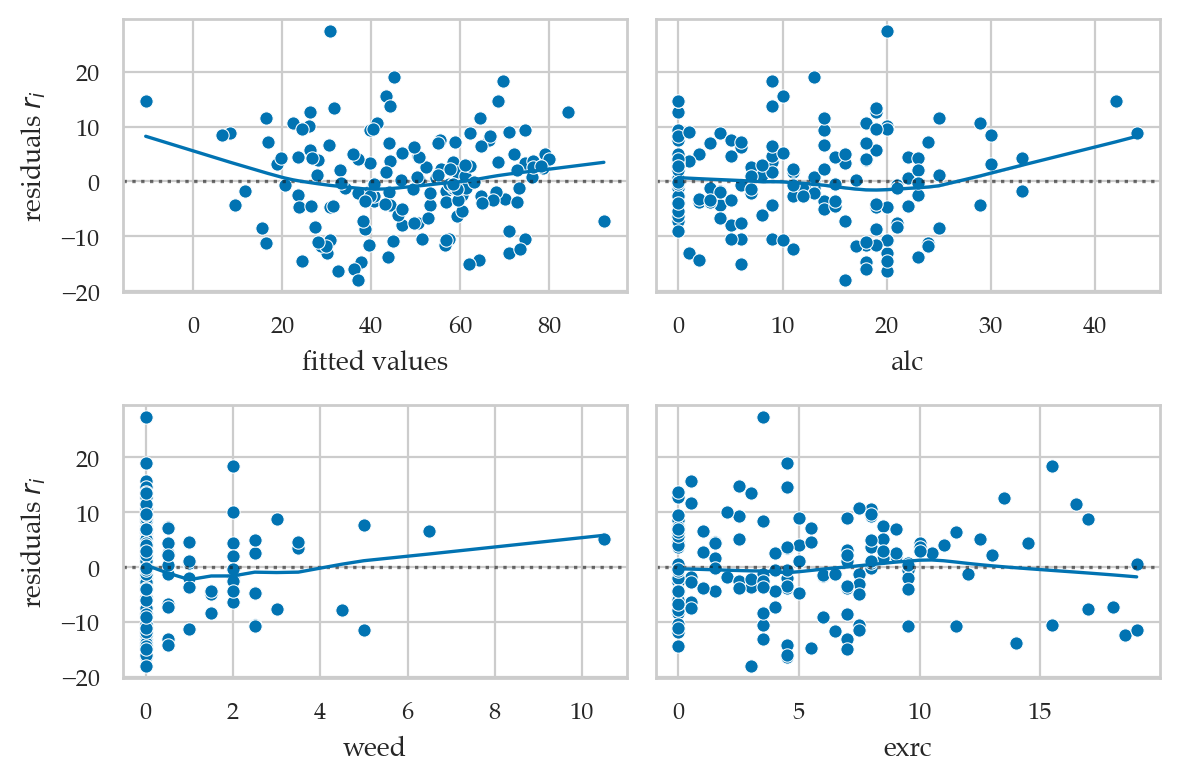

In [38]:
from ministats import plot_resid

with plt.rc_context({"figure.figsize":(6,4)}):
    fig, axs_matrix = plt.subplots(2,2, sharey=True)
    axs = [ax for row in axs_matrix for ax in row]

    plot_resid(lm2, pred=None,   lowess=True, ax=axs[0])
    plot_resid(lm2, pred="alc",  lowess=True, ax=axs[1])
    plot_resid(lm2, pred="weed", lowess=True, ax=axs[2])
    plot_resid(lm2, pred="exrc", lowess=True, ax=axs[3])

    filename = os.path.join(DESTDIR, "sleep_scores_resid_plots_with_lowess.pdf")
    savefigure(fig, filename)

### Linearity checks

Look at residuals plots.

### Independence checks

Look at residuals plots.

### Normality checks

Look at residuals plots...

#### QQ plot inspection

Saved figure to figures/lm/interpreting/sleep_scores_resid_qqplot.pdf
Saved figure to figures/lm/interpreting/sleep_scores_resid_qqplot.png


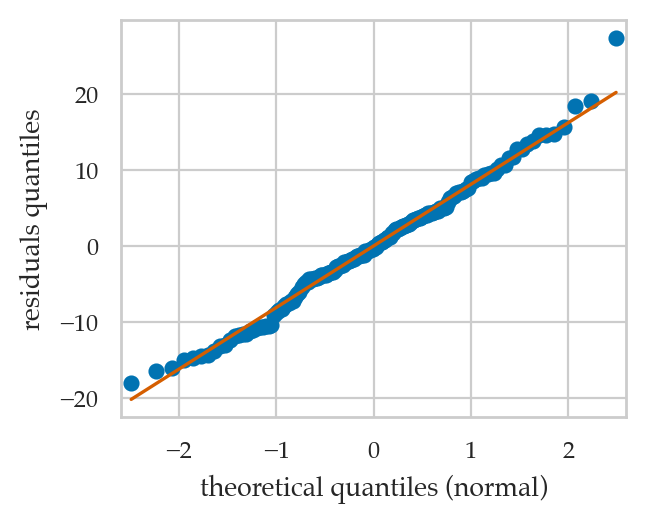

In [39]:
from statsmodels.graphics.api import qqplot
# qqplot(lm2.resid, line="s");

with plt.rc_context({"figure.figsize":(3.3,2.7)}):
    qqplot(lm2.resid, line="s");
    plt.xlabel("theoretical quantiles (normal)")
    plt.ylabel("residuals quantiles")

filename = os.path.join(DESTDIR, "sleep_scores_resid_qqplot.pdf")
savefigure(plt.gcf(), filename)

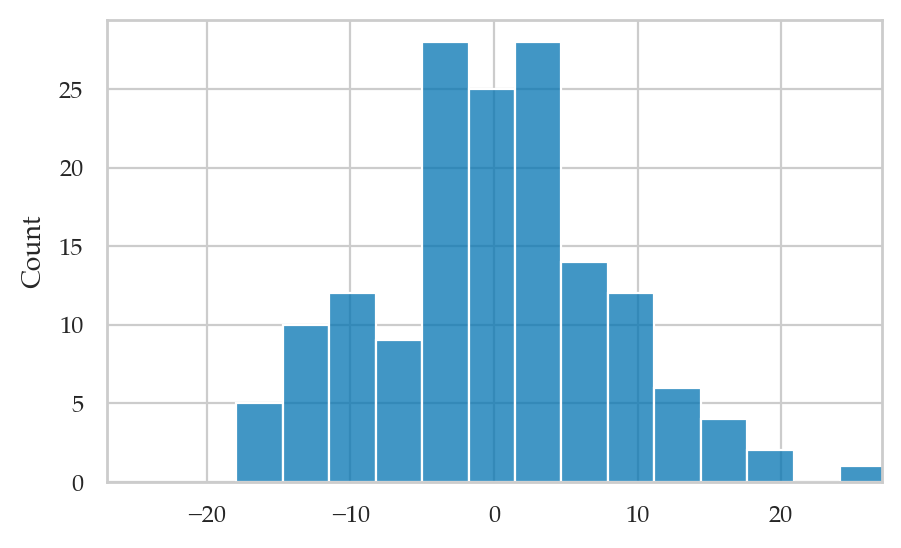

In [40]:
# BONUS
ax = sns.histplot(lm2.resid)
ax.set_xlim([-27,27]);

#### Skew and kurtosis

In [41]:
from scipy.stats import skew
from scipy.stats import kurtosis

skew(lm2.resid), kurtosis(lm2.resid, fisher=False)

(0.18224568453683496, 3.0747952385562636)

### Homoscedasticity checks

The scale-location plot allows us to see if pattern in the variance of the residuals exists.


Saved figure to figures/lm/interpreting/sleep_scores_scale-location_plot.pdf
Saved figure to figures/lm/interpreting/sleep_scores_scale-location_plot.png


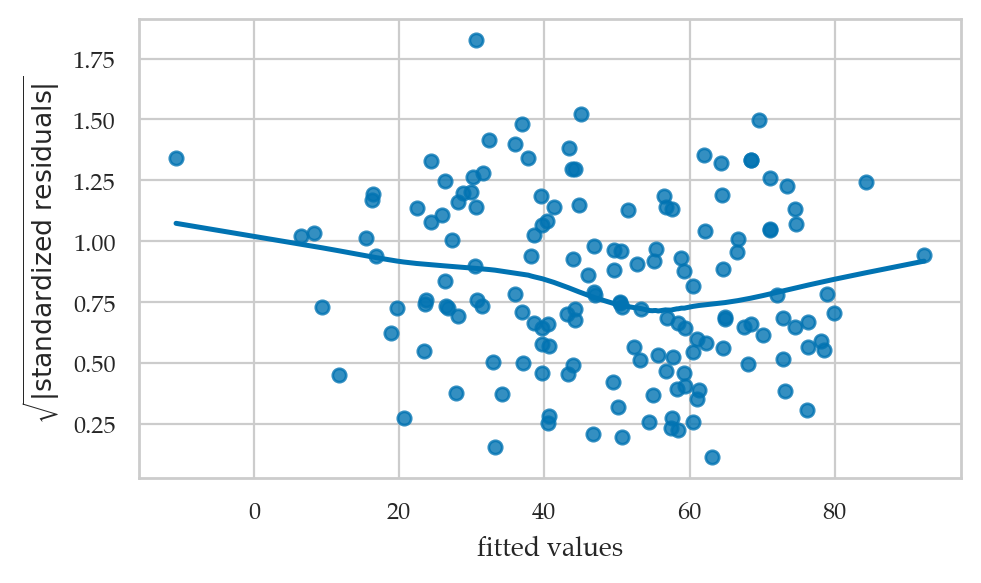

In [42]:
from ministats import plot_scaleloc

plot_scaleloc(lm2);

# FIGURES ONLY
filename = os.path.join(DESTDIR, "sleep_scores_scale-location_plot.pdf")
savefigure(plt.gcf(), filename)

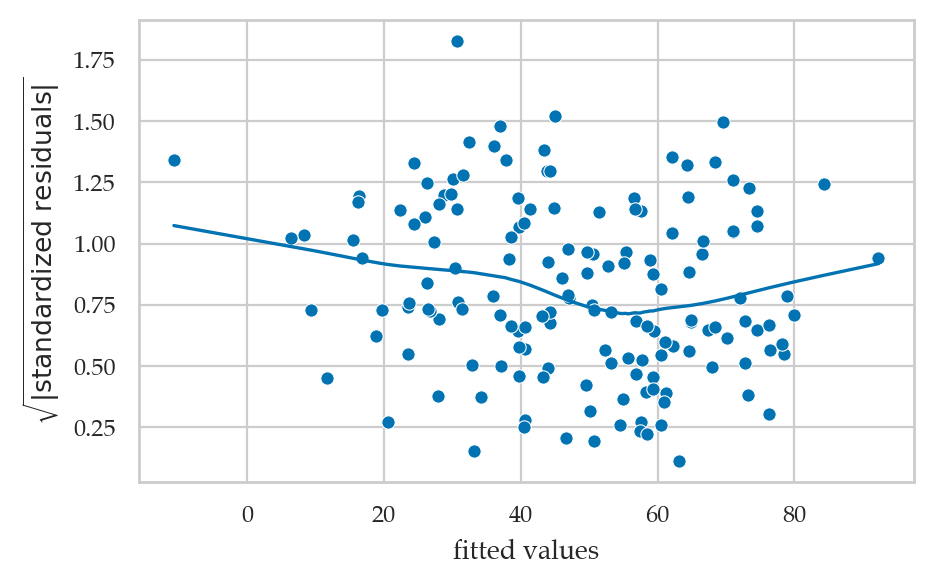

In [43]:
# ALT. Generate the scale-location plot from scratch

# 1. Compute the square root of the standardized residuals
scorehats = lm2.fittedvalues
std_resids = lm2.resid / np.sqrt(lm2.scale)
sqrt_std_resids = np.sqrt(np.abs(std_resids))

# 2. Generate the scatter plot
ax = sns.scatterplot(x=scorehats, y=sqrt_std_resids)

# 3. Add the LOWESS curve
from statsmodels.nonparametric.smoothers_lowess import lowess
xgrid, ylowess = lowess(sqrt_std_resids, scorehats).T
sns.lineplot(x=xgrid, y=ylowess, ax=ax)

# 4. Add descriptive labels
ax.set_ylabel(r"$\sqrt{|\text{standardized residuals}|}$")
ax.set_xlabel("fitted values");

### Collinearity checks

#### Check the correlation matrix

In [44]:
corrM = doctors[["alc", "weed", "exrc"]].corr()
corrM.round(4)

,alc,weed,exrc
alc,1.0000,0.0422,0.0336
weed,0.0422,1.0000,0.0952
exrc,0.0336,0.0952,1.0000


In [45]:
# # BONUS 1 (not covered anywhere earlier in the book)
# sns.heatmap(corrM, annot=True, fmt='.2f', cmap="Grays");

In [46]:
# # BONUS 2 (not covered anywhere earlier in the book)
# sns.pairplot(doctors[["alc", "weed", "exrc"]]);

#### Condition number

In [47]:
lm2.condition_number

31.229721453770164

In [48]:
# ALT. (compute from scratch)
#######################################################
X = sm.add_constant(doctors[["alc","weed","exrc"]])
eigvals = np.linalg.eigvals(X.T @ X)
lam_max, lam_min = np.max(eigvals), np.min(eigvals)
np.sqrt(lam_max/lam_min)

31.229721453770264

#### Variance inflation factor

In [49]:
from ministats import calc_lm_vif

calc_lm_vif(lm2, "alc"), calc_lm_vif(lm2, "weed"), calc_lm_vif(lm2, "exrc")

(1.0026692156304757, 1.010703145007322, 1.010048809433661)

In [50]:
# ALT. using variance_inflation_factor from statsmodels
from statsmodels.stats.outliers_influence \
     import variance_inflation_factor as statsmodels_vif

X = sm.add_constant(doctors[["alc","weed","exrc"]])
statsmodels_vif(X, 1)  # variation inflation factor of "alc" in lm2

1.0026692156304757

#### Perfect multicollinearity example

In [51]:
doctorscol = doctors.copy()
doctorscol["alc2"] = doctors["alc"]
formula2col = "score ~ 1 + alc + alc2 + weed + exrc"
lm2col = smf.ols(formula2col, data=doctorscol).fit()
lm2col.params

Intercept    60.452901
alc          -0.900051
alc2         -0.900051
weed         -1.021552
exrc          1.768289
dtype: float64

In [52]:
calc_lm_vif(lm2col, "alc")

/Users/ivan/Projects/Minireference/software/ministats/ministats/linear_models.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


inf

## Outliers and influential observations

TODO: definitions

Saved figure to figures/lm/interpreting/panel_outlier_hl_influential.pdf
Saved figure to figures/lm/interpreting/panel_outlier_hl_influential.png


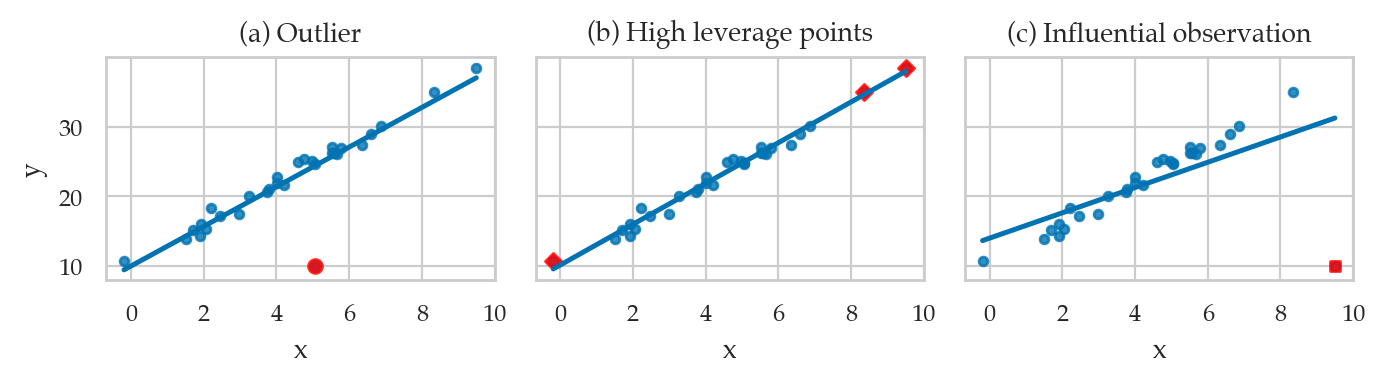

In [53]:
# FIGURES ONLY
from scipy.stats import norm

npts = 30
beta_0 = 10
beta_x = 3
sigma = 1

np.random.seed(45)

xs = norm(loc=5, scale=2).rvs(npts)
ys = beta_0 + beta_x*xs + norm(0,sigma).rvs(npts)
dfxys = pd.DataFrame({"x":xs, "y":ys})

# outlier near middle
idx_mid = dfxys[dfxys["x"]>5].sort_values("x").head(1).index[0]
y1s = dfxys["y"].copy()
y1s[idx_mid] = 10
dfxys["y1"] = y1s
mask_outl = (y1s == 10)
dfxys["outl"] = mask_outl

# high leverage points
dfxys["y2"] = ys
mask_hl = (dfxys["x"] < 1) | (dfxys["x"] > 7.5)
dfxys["hl"] = mask_hl


# influential point near end
idx_last = dfxys.sort_values("x").tail(1).index[0]
y3s = dfxys["y"].copy()
y3s[idx_last] = 10
dfxys["y3"] = y3s
mask_infl = (y3s == 10)
dfxys["infl"] = mask_infl


SIZE_SCATTER = 10


with plt.rc_context({"figure.figsize":(7,2)}):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
    # fig.subplots_adjust(wspace=0.5)

    # (A) Outlier
    sns.regplot(x="x", y="y1", ci=False, data=dfxys,
                scatter_kws={"s":SIZE_SCATTER}, ax=ax1)
    dfoutl = dfxys[dfxys["outl"]==True]
    sns.regplot(x="x", y="y1", ci=False, data=dfoutl,
                fit_reg=False, color="red", scatter_kws={"s":25}, marker="o", ax=ax1)
    ax1.set_ylabel("y")
    # ax1.set_ylabel("$y_1$")
    ax1.set_xlabel("x")
    ax1.set_xticks(range(0,12,2))
    ax1.set_title("(a) Outlier")

    # (B) High leverage points
    sns.regplot(x="x", y="y2", ci=False, data=dfxys,
                scatter_kws={"s":SIZE_SCATTER},  ax=ax2)
    dfhl = dfxys[dfxys["hl"]==True]
    sns.regplot(x="x", y="y2", ci=False, data=dfhl,
                fit_reg=False, color="red", scatter_kws={"s":17}, marker="D", ax=ax2)
    # ax2.set_ylabel("$y_2$")
    ax2.set_ylabel(None)
    ax2.set_xlabel("x")
    ax2.set_xticks(range(0,12,2))
    ax2.set_title("(b) High leverage points")

    # (C) Influential observation
    sns.regplot(x="x", y="y3", ci=False, data=dfxys,
                scatter_kws={"s":SIZE_SCATTER},  ax=ax3)
    dfinfl = dfxys[dfxys["infl"]==True]
    sns.regplot(x="x", y="y3", ci=False, data=dfinfl,
                fit_reg=False, color="red", scatter_kws={"s":15}, marker="s", ax=ax3)
    # ax3.set_ylabel("$y_3$")
    ax3.set_ylabel(None)
    ax3.set_xlabel("x")
    ax3.set_xticks(range(0,12,2))
    ax3.set_title("(c) Influential observation")

    filename = os.path.join(DESTDIR, "panel_outlier_hl_influential.pdf")
    savefigure(fig, filename)

### Leverage and influence metrics

TODO: add definitions of quantities in point form


### Leverage plots

Saved figure to figures/lm/interpreting/lm2_plot_leverage_resid2.pdf
Saved figure to figures/lm/interpreting/lm2_plot_leverage_resid2.png


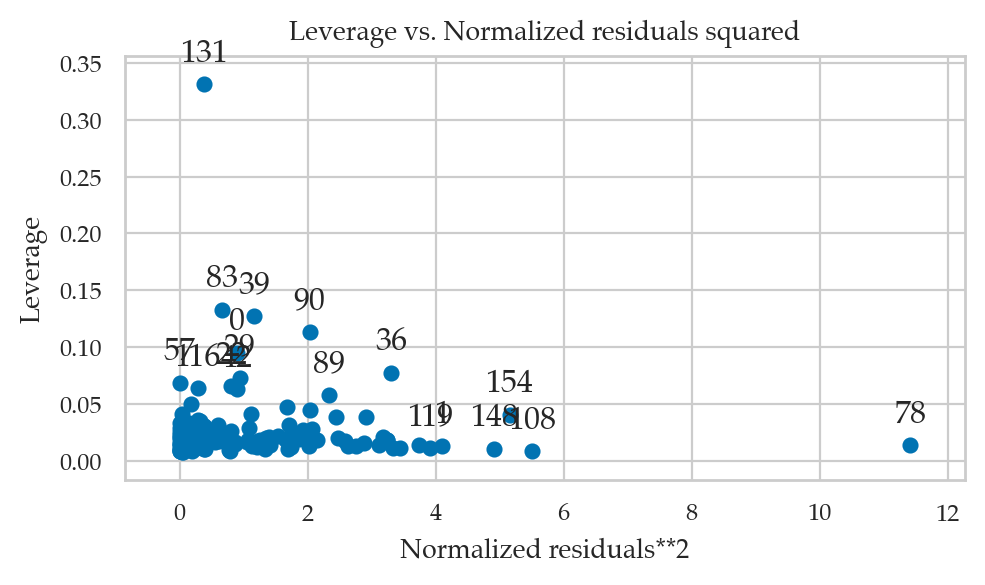

In [54]:
from statsmodels.graphics.api import plot_leverage_resid2

plot_leverage_resid2(lm2);

# FIGURES ONLY
filename = os.path.join(DESTDIR, "lm2_plot_leverage_resid2.pdf")
savefigure(plt.gcf(), filename)

### Influence plots

Saved figure to figures/lm/interpreting/lm2_influence_plot_cook.pdf
Saved figure to figures/lm/interpreting/lm2_influence_plot_cook.png


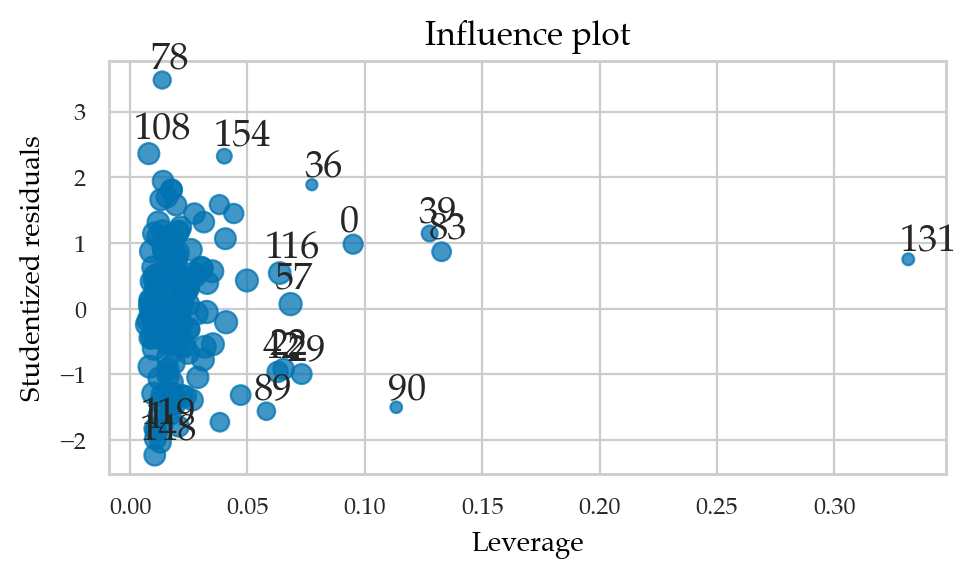

In [55]:
from statsmodels.graphics.api import influence_plot

influence_plot(lm2, criterion="cooks", size=4);

# FIGURES ONLY
ax = plt.gca()
title_font = 12
label_font = 10
ax.set_ylabel("Studentized residuals", fontsize=label_font)
ax.set_xlabel("Leverage", fontsize=label_font)
ax.set_title("Influence plot", fontsize=title_font)
filename = os.path.join(DESTDIR, "lm2_influence_plot_cook.pdf")
savefigure(plt.gcf(), filename)

## Model predictions

### Prediction on the dataset

In [56]:
lm2.fittedvalues

0      55.345142
1      32.408174
2      71.030821
3      56.789073
4      57.514154
         ...    
151    58.867105
152    43.049719
153    57.728460
154    69.617361
155    78.135788
Length: 156, dtype: float64

### Prediction for new data

In [57]:
newdoc = {"alc":3, "weed":1, "exrc":8}
lm2.predict(newdoc)

0    68.177355
dtype: float64

In [58]:
newdoc_score_pred = lm2.get_prediction(newdoc)
newdoc_score_pred.conf_int(obs=True, alpha=0.1)

array([[54.50324518, 81.85146489]])

### In-sample prediction accuracy

In [59]:
# Compute the in-sample mean squared error (MSE)
scores = doctors['score']
scorehats = lm2.fittedvalues
mse = np.mean( (scores - scorehats)**2 )
mse

65.56013803717558

In [60]:
# ALT.
lm2.ssr/n

65.56013803717559

In [61]:
# # ALT2.
# from statsmodels.tools.eval_measures import mse
# mse(scores,scorehats)

### Out-of-sample prediction accuracy

TODO: explain

### Leave-one-out cross-validation


In [62]:
loo_preds = np.zeros(n)
for i in range(n):
    doctors_no_i = doctors.drop(index=i)
    lm2_no_i = smf.ols(formula,data=doctors_no_i).fit()
    predictors_i = dict(doctors.loc[i,:])
    pred_i = lm2_no_i.predict(predictors_i)[0]
    loo_preds[i] = pred_i

# Calculate the out-of-sample mean squared error
mse_loo = np.mean( (doctors['score'] - loo_preds)**2 )
mse_loo

69.20054514710948

Compare with the in-sample MSE of the model which is lower.

In [63]:
lm2.ssr/n

65.56013803717559

#### Towards machine learning

The out-of-sample prediction accuracy is a common metric used in machine learning (ML) tasks.

## Explanations

### Adjusted $R^2$

TODO: show formula

In [64]:
# TODO 

### Calculating standard error of parameters (optional)

In [65]:
lm2.bse

Intercept    1.289380
alc          0.069973
weed         0.476166
exrc         0.138056
dtype: float64

In [66]:
# construct the design matrix for the model 
X = sm.add_constant(doctors[["alc","weed","exrc"]])
# calculate the diagonal of the inverse-covariance matrix
inv_covs = np.diag(np.linalg.inv(X.T.dot(X)))
sigmahat*np.sqrt(inv_covs)

array([1.28938008, 0.06997301, 0.4761656 , 0.13805557])

In [67]:
# these lead to approx. same result because predictors are not correlated
# but the correct formula is to use the inv. covariance matrix as above.
sum_alc_dev2 = np.sum((doctors["alc"] - doctors["alc"].mean())**2)
sum_weed_dev2 = np.sum((doctors["weed"] - doctors["weed"].mean())**2)
sum_exrc_dev2 = np.sum((doctors["exrc"] - doctors["exrc"].mean())**2)
se_b_alc = sigmahat / np.sqrt(sum_alc_dev2)
se_b_weed = sigmahat / np.sqrt(sum_weed_dev2)
se_b_exrc = sigmahat / np.sqrt(sum_exrc_dev2)
se_b_alc, se_b_weed, se_b_exrc

(0.06987980522527788, 0.47363764322385443, 0.13736710473639846)

### Metrics for influential observations

#### Leverage score

$$
h_i = 1 - \frac{r_i}{r_{i(i)}},
$$

In [68]:
infl = lm2.get_influence()
infl.hat_matrix_diag[0:5]

array([0.09502413, 0.0129673 , 0.01709783, 0.01465484, 0.00981632])

#### Studentized residuals 

$$
  t_{i} = \frac{r_i}{\hat{\sigma}_{(i)} \sqrt{1-h_i}}
$$

In [69]:
infl.resid_studentized_external[0:5]

array([ 0.98085317, -2.03409243, -1.61072775, -0.21903275, -1.29094028])

#### Cook's distance

$$
D_i  = \frac{r_i^2}{p \, \widehat{\sigma}^2} \cdot \frac{h_{i}}{(1-h_{i})^2}
      % = \frac{t_i^2 }{p}\frac{h_i}{1-h_i}
$$


In [70]:
infl.cooks_distance[0][0:5]

array([0.02526116, 0.01331454, 0.01116562, 0.00017951, 0.0041123 ])

#### DFFITS diagnostic

$$
\textrm{DFFITS}_i = \frac{ \widehat{y}_i - \widehat{y}_{i(i)} }{ \widehat{\sigma}_{(i)} \sqrt{h_i} }.
$$

In [71]:
infl.dffits[0][0:5]

array([ 0.31783554, -0.23314692, -0.21244055, -0.02671194, -0.12853536])

#### Calculating leverage and influence metrics using `statsmodels`

In [72]:
infl = lm2.get_influence()
infl_df = infl.summary_frame()
# list(infl_df.columns)

In [73]:
cols = ["student_resid", "hat_diag", "cooks_d", "dffits"]
infl_df[cols].round(3).head(5)

,student_resid,hat_diag,cooks_d,dffits
0,0.981,0.095,0.025,0.318
1,-2.034,0.013,0.013,-0.233
2,-1.611,0.017,0.011,-0.212
3,-0.219,0.015,0.000,-0.027
4,-1.291,0.010,0.004,-0.129


### Hypothesis tests for checking linear model assumptions

In [74]:
lm2.diagn

{'jb': 0.8999138579592632,
 'jbpv': 0.6376556155083237,
 'skew': 0.18224568453683496,
 'kurtosis': 3.0747952385562636,
 'omni': 1.1403999852814017,
 'omnipv': 0.5654123490825906,
 'condno': 31.229721453770164,
 'mineigval': 40.14996367643264}

#### Hypothesis test for linearity

In [75]:
sms.linear_harvey_collier(lm2)

TtestResult(statistic=1.4317316989777105, pvalue=0.15427366179829397, df=152)

#### Normality tests

In [76]:
from statsmodels.stats.stattools import omni_normtest

omni, omnipv = omni_normtest(lm2.resid)
omni, omnipv

(1.1403999852814017, 0.5654123490825906)

In [77]:
from statsmodels.stats.stattools import jarque_bera

jb, jbpv, skew, kurtosis = jarque_bera(lm2.resid)
jb, jbpv, skew, kurtosis

(0.8999138579592632,
 0.6376556155083237,
 0.18224568453683496,
 3.0747952385562636)

#### Independence test (autocorrelation)

In [78]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(lm2.resid)

1.8284830211766727

#### Homoskedasticity tests


##### Breusch-Pagan
https://en.wikipedia.org/wiki/Breusch-Pagan_test

In [79]:
lm, p_lm, _, _ = sms.het_breuschpagan(lm2.resid, lm2.model.exog)
lm, p_lm

(6.254809752854315, 0.09985027888796541)

##### Goldfeld-Quandt test

https://en.wikipedia.org/wiki/Goldfeld-Quandt_test


In [80]:
# sort by score
idxs = doctors.sort_values("alc").index

# sort by scorehats
idxs = np.argsort(lm2.fittedvalues)
X = lm2.model.exog[idxs,:]
resid = lm2.resid[idxs]

# run the test
F, p_F, _ = sms.het_goldfeldquandt(resid, X, idx=1)
F, p_F

(1.5346515257083702, 0.03369473000286662)

## Discussion

### Maximum likelihood estimate

In [81]:
from scipy.optimize import minimize
from scipy.stats import norm

n = len(doctors)
preds = doctors[["alc", "weed", "exrc"]]
scores = doctors["score"]

def negloglikelihood(betas):
    scorehats = betas[0] + (betas[1:]*preds).sum(1)
    residuals = scores - scorehats
    SSR = np.sum(residuals**2)
    sigmahat = np.sqrt(SSR/(n-3-1))
    likelihoods = norm.pdf(residuals,scale=sigmahat)
    loglikelihood = np.sum(np.log(likelihoods))
    return -1 * loglikelihood

betas = minimize(negloglikelihood, x0=[0,0,0,0]).x
betas

array([60.4528995 , -1.80010127, -1.02155223,  1.76828879])

In [82]:
lm2.params.values

array([60.45290059, -1.80010132, -1.02155166,  1.76828876])

### Regularization

In [83]:
doctors[["alc", "weed", "exrc"]].std()

alc     9.428506
weed    1.391068
exrc    4.796361
dtype: float64

In [84]:
# TRUE
# alc =  - 1.8
# weed = - 0.5
# exrc = + 1.9

# FITTED
lm2.params

Intercept    60.452901
alc          -1.800101
weed         -1.021552
exrc          1.768289
dtype: float64

#### L1 regularization (LASSO)

Set `alpha` option to the desired value $\alpha_1$ and `L1_wt = 1`,
which means $100\%$ L1 regularization.

In [85]:
lm2_L1reg = smf.ols(formula, data=doctors) \
               .fit_regularized(alpha=0.3, L1_wt=1.0)
lm2_L1reg.params

Intercept    58.930367
alc          -1.763306
weed          0.000000
exrc          1.795228
dtype: float64

#### L2 regularization (ridge)

Set `alpha` option to the desired value $\alpha_2$ and `L1_wt = 0`,
which means $0\%$ L1 regularization and $100\%$ L2 regularization.

In [86]:
lm2_L2reg = smf.ols(formula, data=doctors) \
               .fit_regularized(alpha=0.05, L1_wt=0.0001)
lm2_L2reg.params

Intercept    50.694960
alc          -1.472536
weed         -0.457425
exrc          2.323386
dtype: float64

### Statsmodels diagnostics plots (BONUS TOPIC)

TODO: import explanations from .tex

#### Plot fit against one regressor

see https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.plot_fit.html

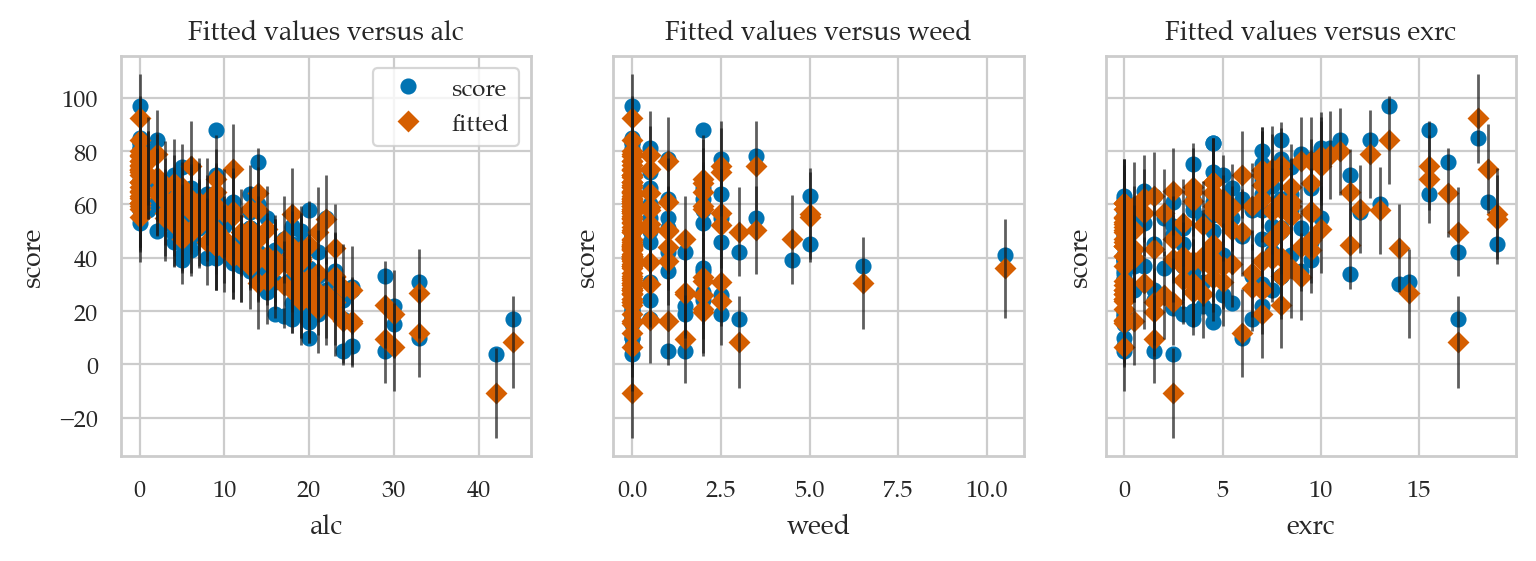

In [87]:
from statsmodels.graphics.api import plot_fit

with plt.rc_context({"figure.figsize":(9,2.6)}):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
    plot_fit(lm2, "alc",  ax=ax1)
    plot_fit(lm2, "weed", ax=ax2)
    plot_fit(lm2, "exrc", ax=ax3)
    ax2.get_legend().remove()
    ax3.get_legend().remove()

#### Partial regression plot

https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.plot_partregress.html


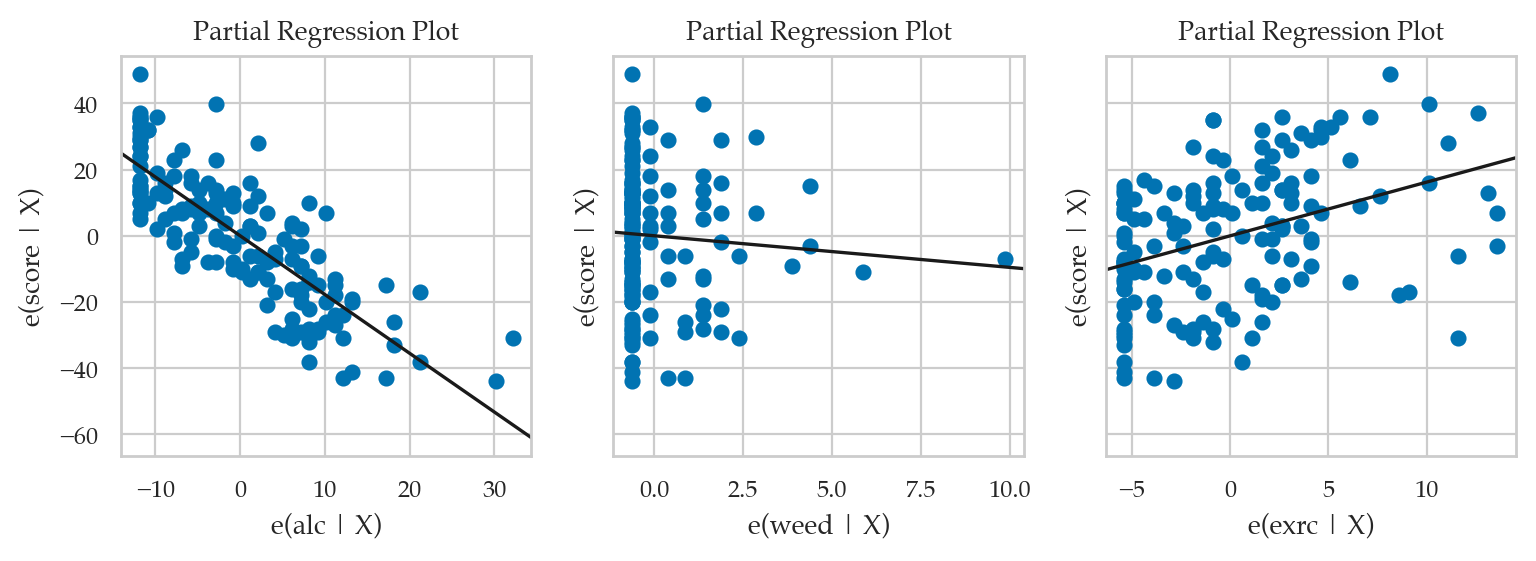

In [88]:
from statsmodels.graphics.api import plot_partregress

with plt.rc_context({"figure.figsize":(9,2.6)}):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
    plot_partregress("score", "alc",  exog_others=[], data=doctors, obs_labels=False, ax=ax1)
    plot_partregress("score", "weed", exog_others=[], data=doctors, obs_labels=False, ax=ax2)
    plot_partregress("score", "exrc", exog_others=[], data=doctors, obs_labels=False, ax=ax3)

#### CCPR plot

component and component-plus-residual

see https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.plot_ccpr.html


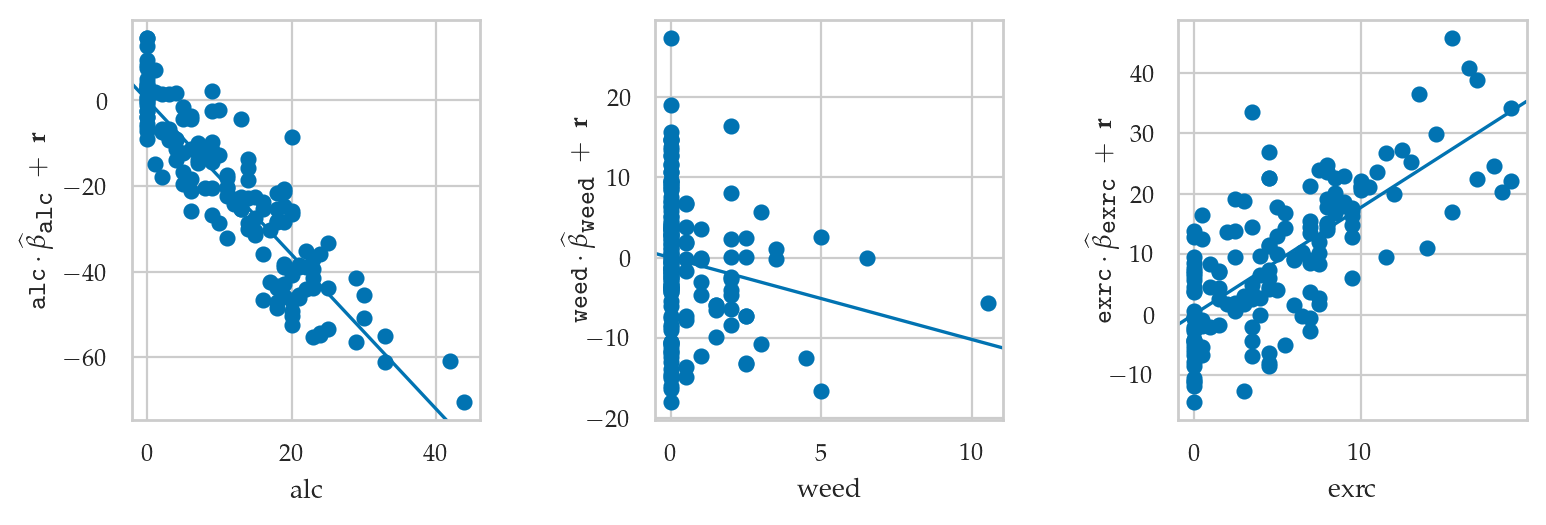

In [89]:
from statsmodels.graphics.api import plot_ccpr

with plt.rc_context({"figure.figsize":(9,2.6), "text.usetex":True}):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3)
    fig.subplots_adjust(wspace=0.5)

    plot_ccpr(lm2, "alc", ax=ax1)
    ax1.set_title("")
    ax1.set_ylabel(r"$\texttt{alc} \cdot \widehat{\beta}_{\texttt{alc}} \; + \; \mathbf{r}$")

    plot_ccpr(lm2, "weed", ax=ax2)
    ax2.set_title("")
    ax2.set_ylabel(r"$\texttt{weed} \cdot \widehat{\beta}_{\texttt{weed}} \; + \; \mathbf{r}$", labelpad=-3)

    plot_ccpr(lm2, "exrc", ax=ax3)
    ax3.set_title("")
    ax3.set_ylabel(r"$\texttt{exrc} \cdot \widehat{\beta}_{\texttt{exrc}} \; + \; \mathbf{r}$", labelpad=-3)


#### All-in-on convenience method

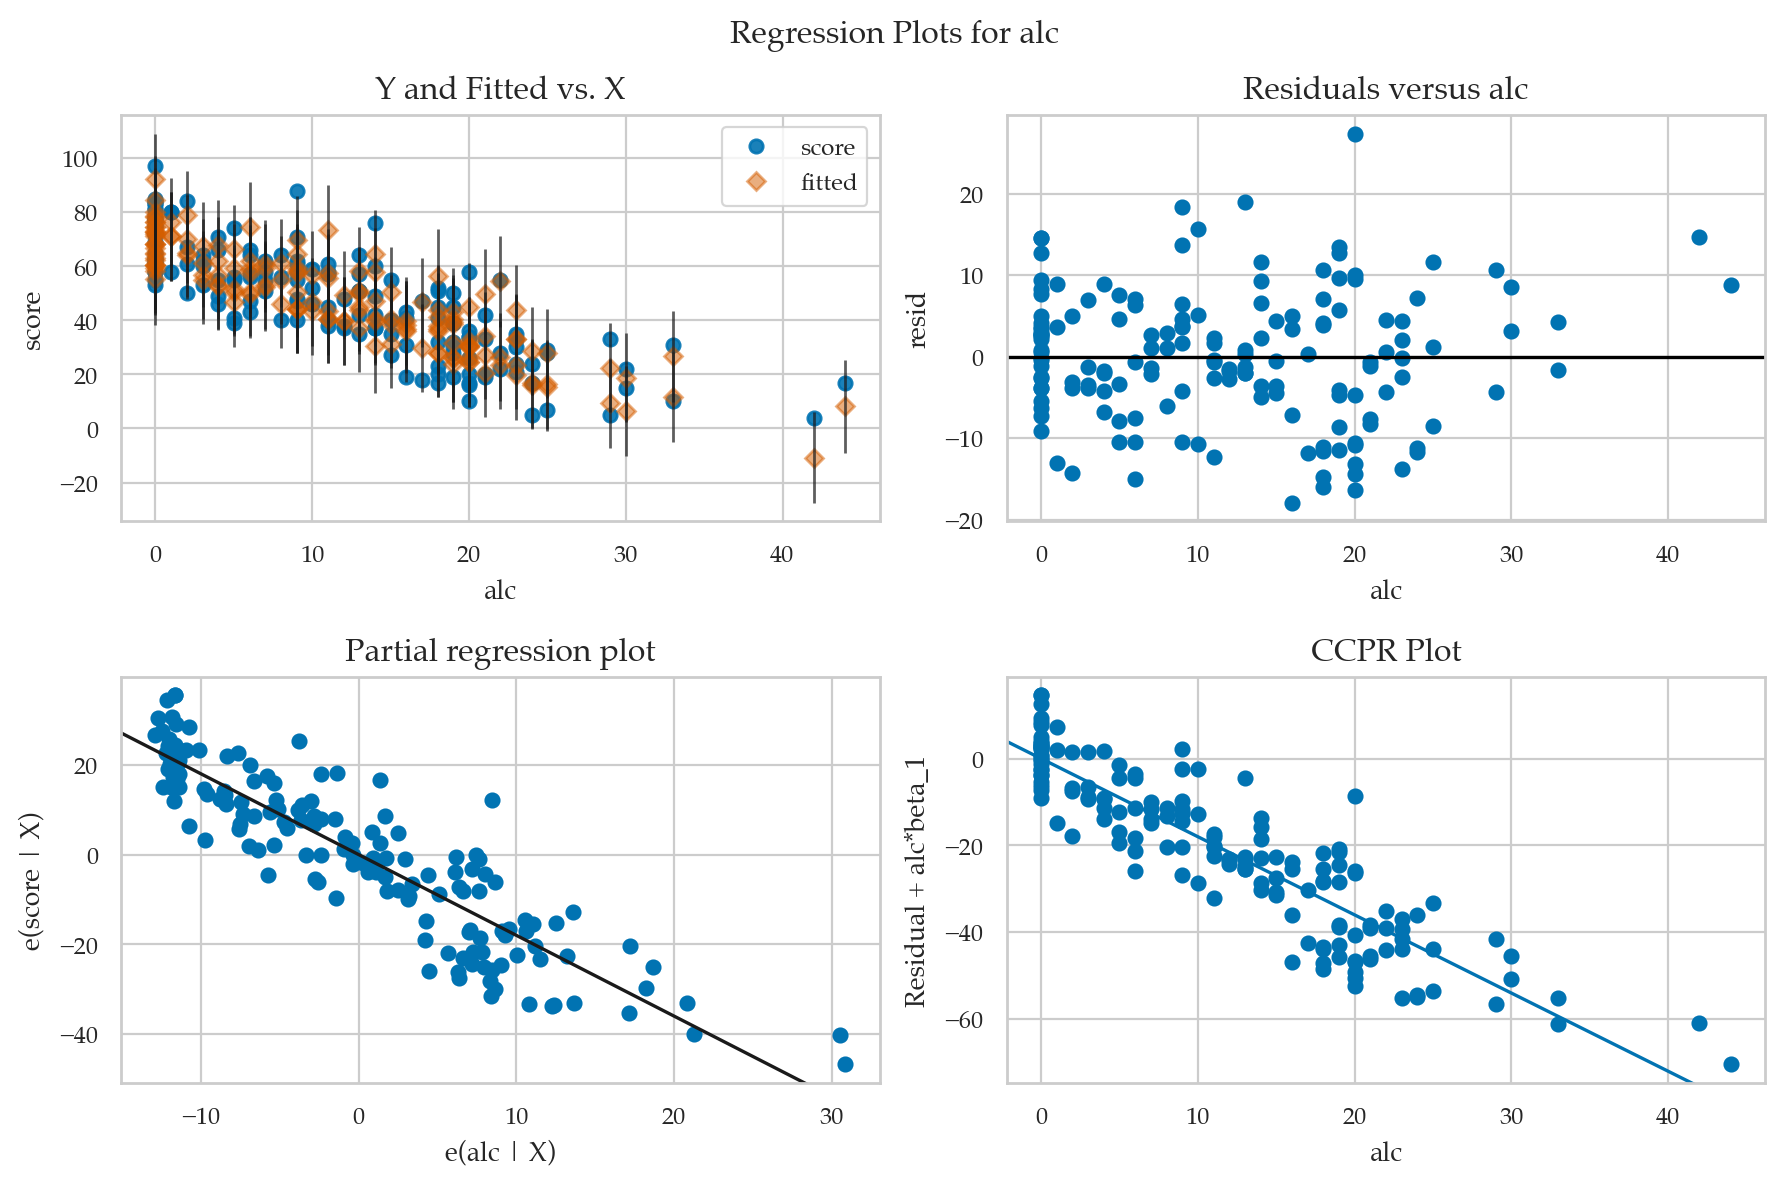

In [90]:
from statsmodels.graphics.api import plot_regress_exog

with plt.rc_context({"figure.figsize":(9,6)}):
    plot_regress_exog(lm2, "alc")

## Exercises

### E4.LOGNORM Non-normal error term

In [91]:
from scipy.stats import uniform, lognorm
np.random.seed(42)
xs = uniform(0,10).rvs(100)
ys = 2*xs + lognorm(1).rvs(100)
df = pd.DataFrame({"x":xs, "y":ys})
lm = smf.ols("y ~ x", data=df).fit()

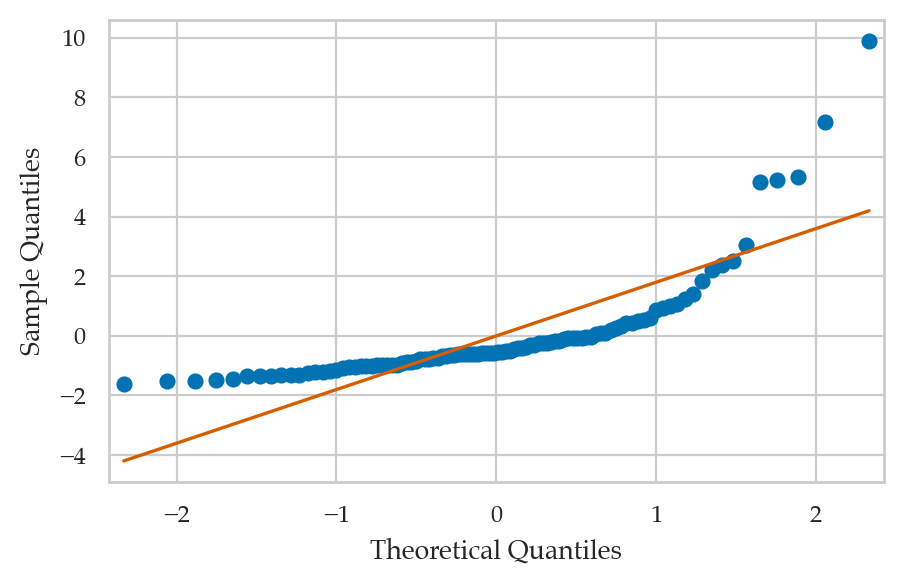

In [92]:
qqplot(lm.resid, line="s");

In [93]:
# sns.scatterplot(x=xs, y=lm.resid);

In [94]:
# from ministats import plot_lm_scale_loc
# plot_lm_scale_loc(lm);

### E4.DEP Dependent error term 

### E4.NL Nonlinear relationship

In [95]:
from scipy.stats import uniform, lognorm

np.random.seed(42)
xs = uniform(0,10).rvs(100)
ys = 2*xs + xs**2 + norm(0,1).rvs(100)
df = pd.DataFrame({"x":xs, "y":ys})
lm = smf.ols("y ~ 1 + x", data=df).fit()
lm.params

Intercept   -14.684585
x            11.688188
dtype: float64

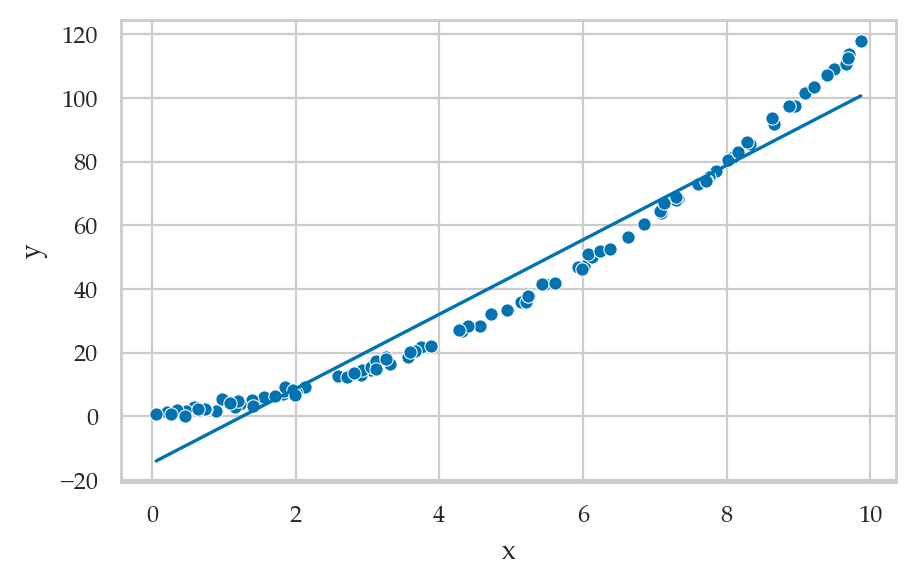

In [96]:
from ministats import plot_reg
plot_reg(lm);

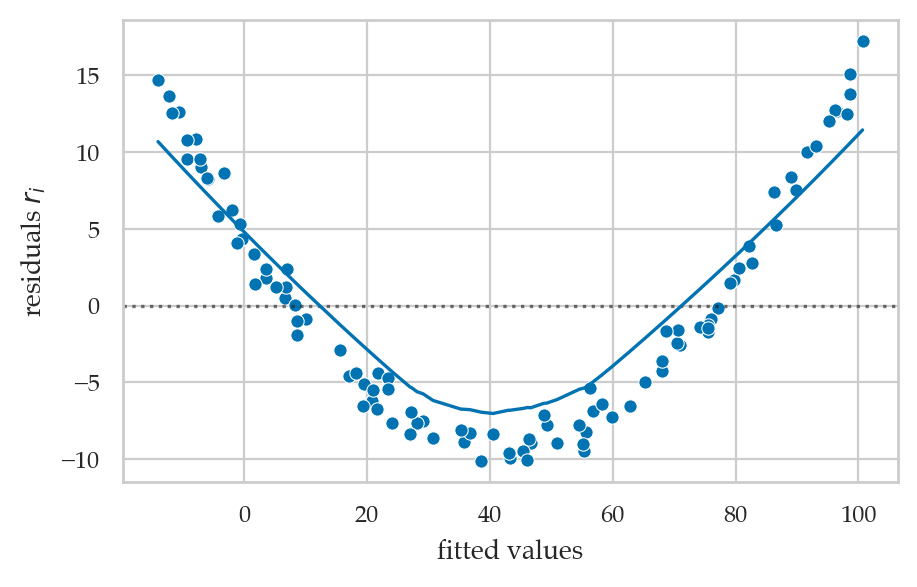

In [97]:
plot_resid(lm, lowess=True);

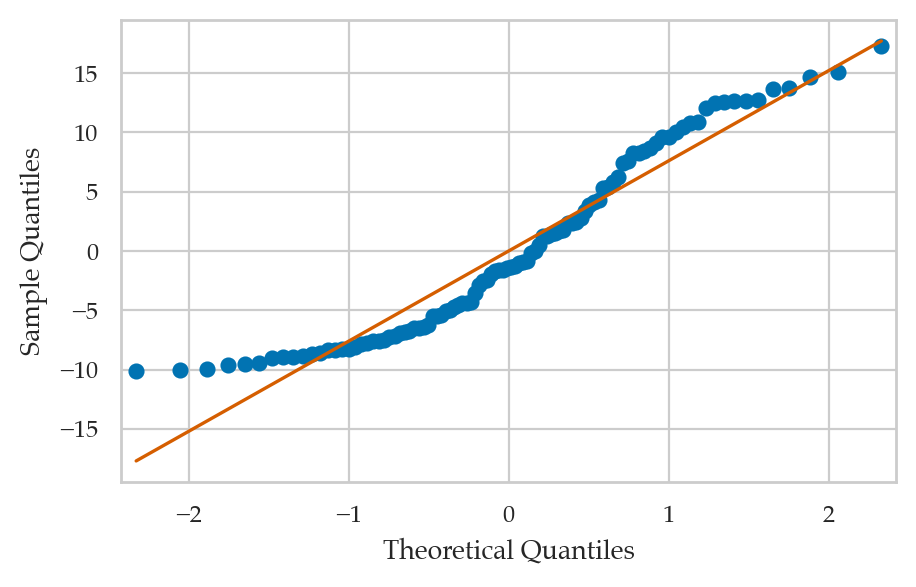

In [98]:
qqplot(lm.resid, line="s");

### E4.H Heteroskedasticity

In [99]:
from scipy.stats import uniform, norm

np.random.seed(43)
xs = np.sort(uniform(0,10).rvs(100))
sigmas = np.linspace(1,20,100)
ys = 2*xs + norm(loc=0,scale=sigmas).rvs(100)
df = pd.DataFrame({"x":xs, "y":ys})
lm = smf.ols("y ~ x", data=df).fit()

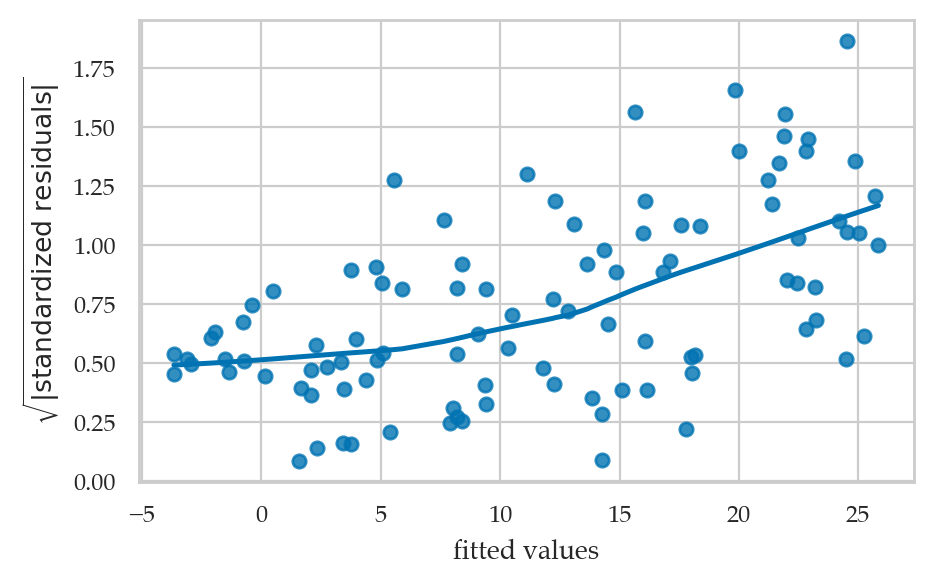

In [100]:
from ministats import plot_scaleloc
plot_scaleloc(lm);

### E4.v Collinearity

In [101]:
from scipy.stats import uniform, norm

np.random.seed(45)
x1s = uniform(0,10).rvs(100)
alpha = 0.8
x2s = alpha*x1s + (1-alpha)*uniform(0,10).rvs(100)
ys = 2*x1s + 3*x2s + norm(0,1).rvs(100)
df = pd.DataFrame({"x1":x1s, "x2":x2s, "y":ys})
lm = smf.ols("y ~ x1 + x2", data=df).fit()
lm.params, lm.bse

(Intercept    0.220927
 x1           1.985774
 x2           3.006225
 dtype: float64,
 Intercept    0.253988
 x1           0.137253
 x2           0.167492
 dtype: float64)

In [102]:
lm.condition_number

24.291898486251146

In [103]:
calc_lm_vif(lm, "x1"), calc_lm_vif(lm, "x2")

(17.17244980334442, 17.17244980334442)

## Links

- More details about model checking
  https://ethanweed.github.io/pythonbook/05.04-regression.html#model-checking
- Statistical Modeling: The Two Cultures paper that explains the importance of out-of-sample predictions for statistical modelling.  
  https://projecteuclid.org/journals/statistical-science/volume-16/issue-3/Statistical-Modeling--The-Two-Cultures-with-comments-and-a/10.1214/ss/1009213726.full

## CUT MATERIAL

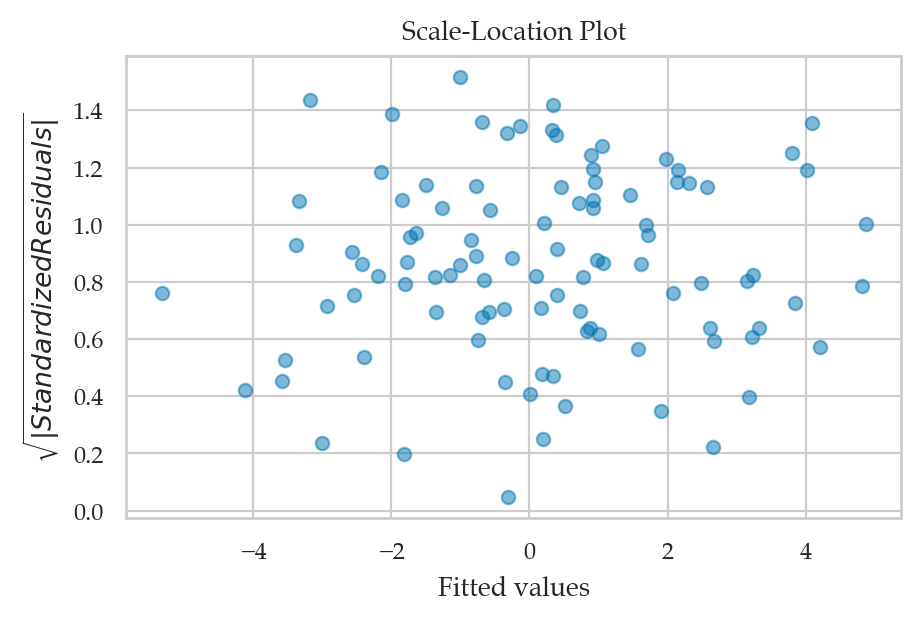

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Generate some data
np.random.seed(0)
X = np.random.normal(size=100)
y = 2 * X + np.random.normal(size=100)

# Fit a regression model
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

# Compute residuals and fitted values
residuals = results.resid
fitted = results.fittedvalues
standardized_residuals = residuals / np.std(residuals)

# Create scale-location plot 
plt.scatter(fitted, np.sqrt(np.abs(standardized_residuals)), alpha=0.5)
plt.xlabel('Fitted values')
plt.ylabel(r'$\sqrt{|Standardized Residuals|}$')
plt.title('Scale-Location Plot')
plt.grid(True)
plt.show()

### Example dataset

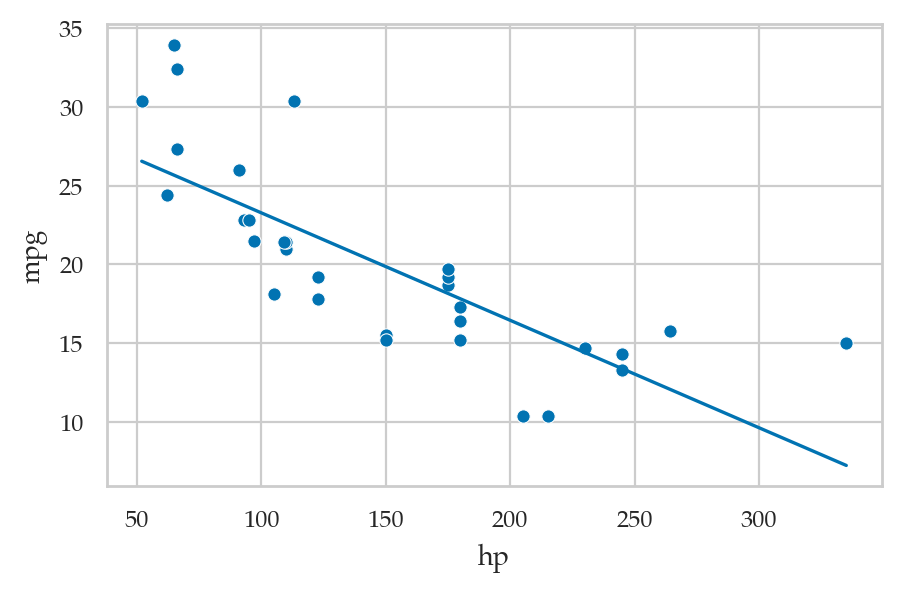

In [105]:
mtcars = sm.datasets.get_rdataset("mtcars", "datasets").data
mtcars

lmcars = smf.ols("mpg ~ hp", data=mtcars).fit()

sns.scatterplot(x=mtcars["hp"], y=mtcars["mpg"])
sns.lineplot(x=mtcars["hp"], y=lmcars.fittedvalues);

#### Compute the variance/covariance matrix


In [106]:
lm2.cov_params()
# == lm2.scale * np.linalg.inv(X.T @ X)
# where X = sm.add_constant(doctors[["alc","weed","exrc"]])

,Intercept,alc,weed,exrc
Intercept,1.662501,-0.055601,-0.093711,-0.095403
alc,-0.055601,0.004896,-0.001305,-0.000288
weed,-0.093711,-0.001305,0.226734,-0.006177
exrc,-0.095403,-0.000288,-0.006177,0.019059


## Marginal effects

In [107]:
import marginaleffects as me
# dir(me)

In [108]:
me.hypotheses(lm2, "Intercept = 0").to_pandas()

,term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
0,Intercept=0,60.452901,1.28938,46.885245,0.0,inf,57.925762,62.980039


In [109]:
me.avg_slopes(lm2).to_pandas()

,term,contrast,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
0,alc,mean(dY/dX),-1.800101,0.069966,-25.728387,0.000000,inf,-1.937231,-1.662971
1,exrc,mean(dY/dX),1.768289,0.138045,12.809467,0.000000,inf,1.497725,2.038853
2,weed,mean(dY/dX),-1.021552,0.475759,-2.147202,0.031777,4.975864,-1.954023,-0.089080


In [110]:
me.avg_comparisons(lm2)

term,contrast,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,str,f64,f64,f64,f64,f64,f64,f64
"""alc""","""+1""",-1.800101,0.069973,-25.725644,0.0,inf,-1.937246,-1.662957
"""exrc""","""+1""",1.768289,0.138056,12.808531,0.0,inf,1.497705,2.038873
"""weed""","""+1""",-1.021552,0.476166,-2.145371,0.031923,4.96925,-1.954819,-0.088284


In [111]:
lm2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,60.4529,1.289,46.885,0.000,57.905,63.000
alc,-1.8001,0.070,-25.726,0.000,-1.938,-1.662
weed,-1.0216,0.476,-2.145,0.034,-1.962,-0.081
exrc,1.7683,0.138,12.809,0.000,1.496,2.041


In [112]:
me.avg_predictions(lm2)

estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
f64,f64,f64,f64,f64,f64,f64
48.025641,0.656747,73.126542,0.0,inf,46.73844,49.312842


In [113]:
me.predictions(lm2)["estimate"].mean()

48.02564102564104

In [114]:
# me.estimands.estimands

In [115]:
# 'plot_common',
# 'plot_comparisons',
# 'plot_predictions',
# 'plot_slopes',
# 'predictions',
# 'slopes'

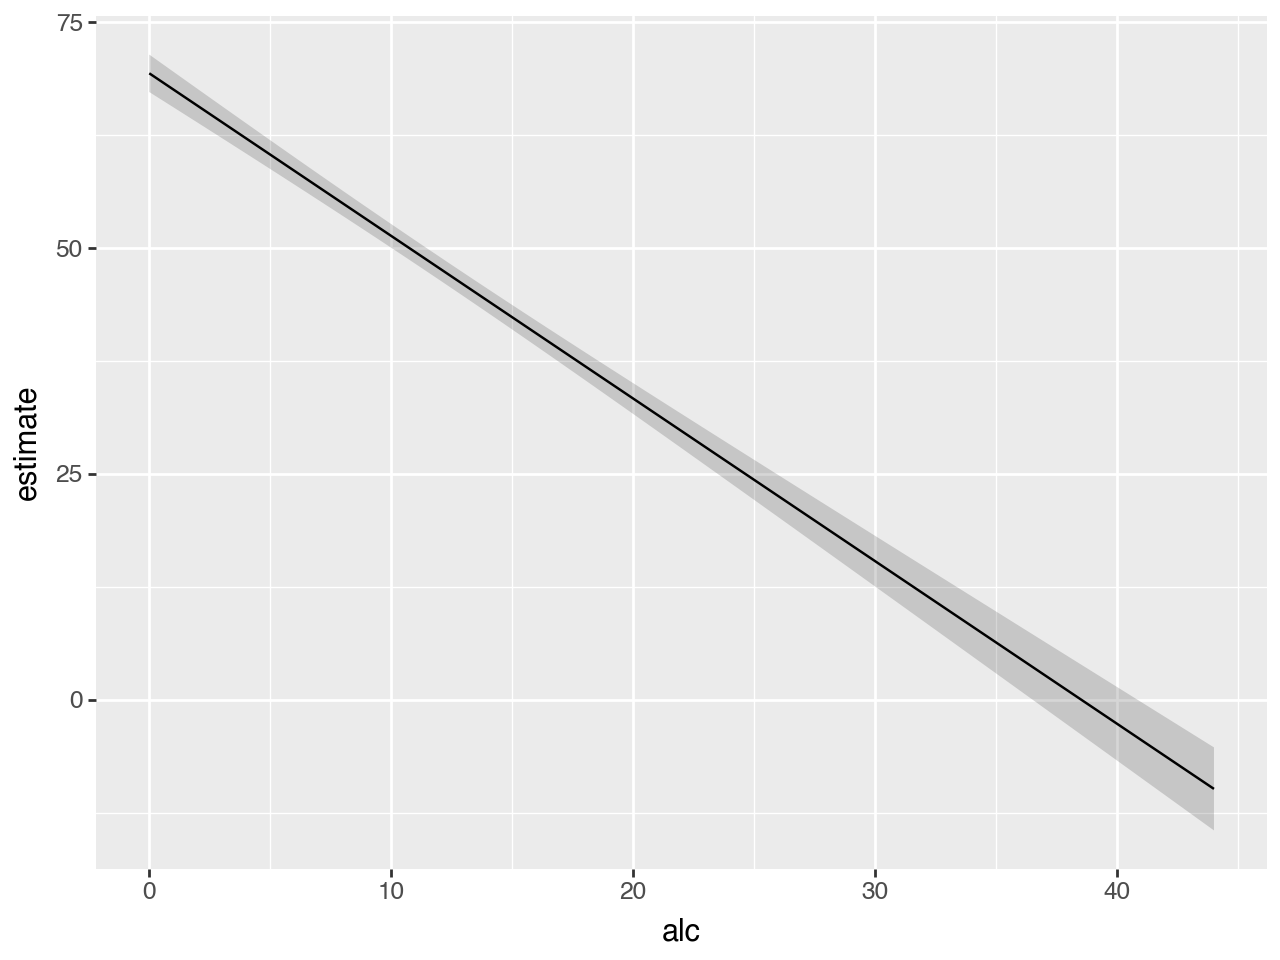

In [116]:
me.plot_predictions(lm2, condition="alc")